In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors
import sys
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import os
import json
from analysis_tools import WaveformProcessingmPMT
from analysis_tools.pulse_finding import do_pulse_finding_vect
import time

In [3]:
def match_hits_waveforms(event):
    #this function acts on one readout window (or event) to match the hits and waveform indices
    
    hit_times  = event["hit_pmt_times"]
    hit_cards  = event["hit_mpmt_card_ids"]
    hit_chan   = event["hit_pmt_channel_ids"]

    wf_start   = event["pmt_waveform_times"]
    wf_wave    = event["pmt_waveforms"]
    wf_end     = wf_start + 8.0 * ak.num(wf_wave)
    wf_card    = event["pmt_waveform_mpmt_card_ids"]
    wf_chan    = event["pmt_waveform_pmt_channel_ids"]

    # ----------------------------------------
    # Vectorized matching
    # ----------------------------------------

    # Broadcast hits vs waveforms
    card_match = hit_cards == wf_card[:, None]
    chan_match = hit_chan == wf_chan[:, None]
    time_match = (hit_times > wf_start[:, None]) & (hit_times < wf_end[:, None])

    match_matrix = card_match & chan_match & time_match  # (wf, hits)
    ##2d array of true and false for matches of each hit to each waveform

    # ----------------------------------------
    # For each hit → find waveform
    # ----------------------------------------
    hit_nmatch = ak.sum(match_matrix, axis=0)
    hit_match_index = ak.where(hit_nmatch>0, ak.argmax(match_matrix, axis=0),-1) 

    # if hit_nmatch==0:
    #     hit_match_index = -1
    # else:
    #     hit_match_index = ak.argmax(match_matrix, axis=0)     # first True or 0

    # Hits with no waveform
    hits_no_wf = hit_times[hit_nmatch == 0]
    
    # ----------------------------------------
    # For each waveform → find hit
    # ----------------------------------------
    wf_nmatch = ak.sum(match_matrix, axis=1)
    wf_match_index = ak.where(wf_nmatch>0, ak.argmax(match_matrix, axis=1),-1) 
    
    # if wf_nmatch==0:
    #     wf_match_index = -1
    # else:
    #     wf_match_index = ak.argmax(match_matrix, axis=1)   # first True or 0
    
    return hit_match_index, wf_match_index 
    

In [4]:
runNumber = 1703
file_path = "/eos/experiment/wcte/data/2025_commissioning/offline_data_vme_match/WCTE_offline_R"+str(runNumber)+"S0_VME_matched.root"

with uproot.open(file_path) as root_file:
    tree = root_file["WCTEReadoutWindows"]
    all_events = tree.arrays(library="ak", entry_start=0, entry_stop=100)


In [5]:
def do_hit_processing(waveforms, waveform_times, waveform_cards, waveform_channels):
    
    #run on self-trigger data 
    
    verbose = False
    
    wf_numpy = ak.to_numpy(waveforms)
    wf_length = 32
    
    # ============================================================
    # SECTION 1) do the pulse finding
    # ============================================================
    start_time = time.time()
    hit_indices = do_pulse_finding_vect(wf_numpy) ##indices of the pulse in each waveform
    hit_indices = ak.Array(hit_indices)
    end_time = time.time()
    if verbose: print(f"Pulse finding took {end_time - start_time:.6f} seconds")

    # ============================================================
    # SECTION 2) now want to make an array of waveforms corresponding 
    #    to each hit with the info needed for CFD and charge calculation
    # ============================================================
    #get the index of the waveform in each case that corresponds to the hit and flatten
    row_wf_index = ak.local_index(hit_indices, axis=0) #returns the index of outer most array - the dimension of wfs
    # essentially[ wf_0, wf_1 wf_2 ...] since this is what was fed into the do_pulse_finding_vect
    hit_wf_index, _ = ak.broadcast_arrays(row_wf_index[:, None], hit_indices)
    # now using broadcast_arrays we broadcast that shape onto hit_indices to produce an array like [[wf_1,wf_1],[wf_2],..] with n hits as second dimension
    #now we flatten
    hit_wf_index = ak.flatten(hit_wf_index) # index of the waveform for each hit
    hit_indices_flat = ak.to_numpy(ak.flatten(hit_indices)) # list of where the hits are in the waveform - flat one for each hit

    #make a full array of the waveforms for each flat hit for later 
    each_hit_waveform = wf_numpy[hit_wf_index] #length of n hits the corresponding full waveform
    
    #slice up the big waveform array into samples we are interested in
    #for each hit where do we want to start the sample in the waveform
    slice_len = 12
    peak_position = 8
    local_idx = np.arange(slice_len)
    start_sample = hit_indices_flat-peak_position
    
    #this makes a 2d array using broadcasting which sample to pick for each element 
    slice_idx = start_sample[:, None] + local_idx[None, :]  # shape (num_hits, slice_len)

    ## hit_idx is shape (n_hits, 1) slice_idx is shape (num_hits, slice_len), they are broadcasted to (num_hits, slice_len)
    # waveform_samples will be shape (num_hits, slice_len) each element waveform_samples[i, j] is each_hit_waveform[hit_idx[i, j],slice_idx[i,j]]
    hit_idx = np.arange(len(hit_indices_flat))[:, None]
    waveform_samples = each_hit_waveform[hit_idx, slice_idx]

    # ============================================================
    # SECTION 3) Now do the charge and time calculations
    # ============================================================
    offlineProcessing = WaveformProcessingmPMT()
    start_time = time.time()
    _,cfd_time_vector_corr,_,_ = offlineProcessing.cfd_vectorized(waveform_samples)
    found_cfd_time = start_sample + cfd_time_vector_corr #relative to start of the waveform
    found_hit_time = waveform_times[hit_wf_index] + (found_cfd_time*8.0) #relative to start of the window
    end_time = time.time()
    if verbose: print(f"Function vectorised took {end_time - start_time:.6f} seconds")

    found_hit_charge = offlineProcessing.charge_vectorized_mPMT_method(waveform_samples,peak_position)
    
    found_hit_card = waveform_cards[hit_wf_index]
    found_hit_chan = waveform_channels[hit_wf_index]

    return found_hit_charge, found_hit_time, found_hit_card, found_hit_chan, hit_wf_index, hit_indices_flat 

    
    

Check should be the same length 904 904
----- Found lack of match -7.626927453182475
hit local index  8
Compare card offline online 132 132
Compare chan offline online 4 4
Compare charge offline online 138.0 138.0
Compare time offline online 7389.296225882353 7450.3116455078125


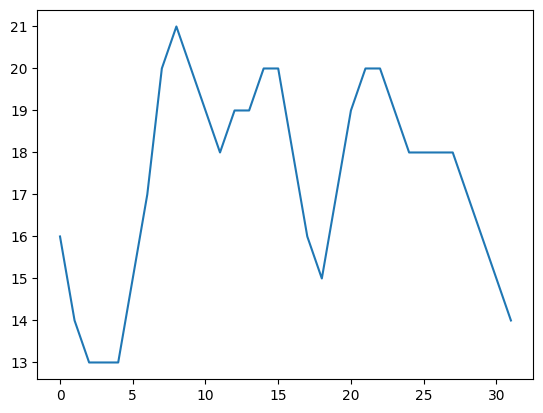

############ Finished procressing event 0 checked 904 waveforms with 1 problems


 1


Check should be the same length 871 871
----- Found lack of match -3.629374006606213
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 267.0 267.0
Compare time offline online 2241.5492364627753 2270.584228515625


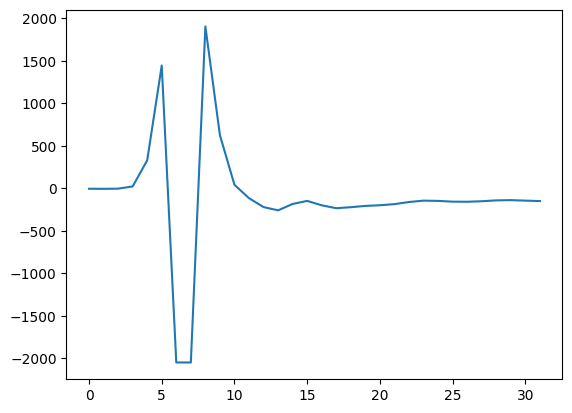

############ Finished procressing event 1 checked 869 waveforms with 1 problems


In [ ]:
for iev, event in enumerate(all_events):
    
    online_hit_times  = event["hit_pmt_times"]
    online_hit_charges  = event["hit_pmt_charges"]
    online_hit_cards  = event["hit_mpmt_card_ids"]
    online_hit_chan   = event["hit_pmt_channel_ids"]

    wf_start   = event["pmt_waveform_times"]
    wf_waveforms    = event["pmt_waveforms"]
    wf_end     = wf_start + 8.0 * ak.num(wf_waveforms)
    wf_card    = event["pmt_waveform_mpmt_card_ids"]
    wf_chan    = event["pmt_waveform_pmt_channel_ids"]

    hit_match_index, wf_match_index  = match_hits_waveforms(event)
    print("Check should be the same length",len(wf_match_index),len(wf_waveforms))

    #select waveforms to process 
    wf_filter = ak.num(wf_waveforms)==32

    wf_process = wf_waveforms[wf_filter]
    wf_process_start = wf_start[wf_filter]
    wf_process_hit_index = wf_match_index[wf_filter]
    wf_process_card = wf_card[wf_filter]
    wf_process_chan = wf_chan[wf_filter]
    
    #outputs a list of hits and the wf_index of the hits hit_wf_index
    found_hit_charge, found_hit_time, found_hit_card, found_hit_chan, hit_wf_index, hit_local_indices = do_hit_processing(wf_process,wf_process_start,wf_process_card,wf_process_chan)

    problem_flag = 0
    for offline_charge, offline_time, offline_card, offline_chan, wf_index, hit_local_index in zip(found_hit_charge, found_hit_time, found_hit_card, found_hit_chan, hit_wf_index, hit_local_indices):
        
        hit_index = wf_process_hit_index[wf_index]
        if hit_index<0:
            print("No hit match for waveform at ", wf_process_start[wf_index])
            continue
        
        # if there is an issue with the timing or charges found
        if np.abs(offline_time-online_hit_times[hit_index])>0.001 or online_hit_charges[hit_index]!=offline_charge :
            problem_flag +=1
            print("----- Found lack of match",(offline_time-online_hit_times[hit_index])/8.0)
            print("hit local index ",hit_local_index)
            print("Compare card offline online",offline_card,online_hit_cards[hit_index])
            print("Compare chan offline online",offline_chan,online_hit_chan[hit_index])
            print("Compare charge offline online",offline_charge,online_hit_charges[hit_index])
            print("Compare time offline online",offline_time,online_hit_times[hit_index])
            fig = plt.figure()
            plt.plot(wf_process[wf_index])
            plt.show()
    
    print("############ Finished procressing event",iev,"checked",len(wf_process),"waveforms with",problem_flag,"problems")
    input()

    


